In [1]:
import urllib.request as request
import tarfile
import os
import parser_subtitles
import xml.etree.ElementTree as ET
import re
from tqdm import tqdm
import unicodedata
from multiprocessing import Pool
import json
from spacy.lang.en import English
import matplotlib
import matplotlib.pyplot as plt
import pickle
import bcolz
import random
import numpy as np

In [2]:
EOS = "<eos>"
SOS = "<sos>"
UNK = "<unk>"
PAD = "<pad>"

params = {
    'seed' : 1337,
    'glovePath' : "/media/data/Datasets/glove",
    'gloveDimension': 50,
    'vocabularyLimit' : 30000,
    'histogramCutoff' : 80,
    'maxSequenceLength' : 40,
    'trainRatio' : 0.9,
    'paramsJSONLocation' : 'subtitles_parameters.json',
    "datasetFile" : 'dataset_ready.pkl',
    'saveDataset' : True,
    "example_item_id" : 19,
}

In [3]:
rootXMLDir = "OpenSubtitles/xml/en/"
dataDir    = "data/"
raw_file   = "raw.json"

In [4]:
random.seed(params['seed'])

## Download the Dataset

In [5]:
# raw dataset download URL
url = "http://opus.lingfil.uu.se/download.php?f=OpenSubtitles/en.tar.gz"
filename = url.split("/")[-1]

In [6]:
# check if we've already downloaded and extracted the file.
flag = "OpenSubtitles" in os.listdir()

In [7]:
if not flag:
    # download dataset
    request.urlretrieve(url, filename)

In [8]:
if not flag:
    # extract dataset.
    response = os.system("unzip " + filename)
    if response == 0:
        print("Successfully unzipped dataset.")

## Setting up Parser

In [9]:
nlp = English()
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe(sentencizer)
tokenizer = nlp.create_pipe("tokenizer")

In [10]:
def search(directory):
    files = []
    for f in os.listdir(directory):
        if os.path.isdir(directory + f):
            files = files + search(directory + f + "/")
        else:
            if f[-4:] == ".xml":
                try:
                    ents = int(directory.split("/")[-2])
                    # i want fresh stuff!
                    if ents >= 2000:
                        files.append(directory + f)
                except:
                    pass
    return files

In [11]:
# search for xml files in the openSubtitles folder.
files = search(rootXMLDir)
print("Using", len(files), "subtitle tracks.")

Using 1539 subtitle tracks.


In [12]:
"""
This is a tqdm loaded multiprocessor!
"""
def processItems(func, args, n_processes = 7):
    p = Pool(n_processes)
    res_list = []
    with tqdm(total = len(args)) as pbar:
        for i, res in enumerate(p.imap_unordered(func, args)):
            pbar.update()
            res_list.append(res)
    pbar.close()
    p.close()
    p.join()
    return res_list

In [13]:
def extractTokenizedPhrases(xmlFilePath):
    tree = ET.parse(xmlFilePath)
    root = tree.getroot()
    
    sequences = []
    # iterates through the lines in the xml file.
    for child in root.findall('s'):
        line = []
        for node in child.getiterator():
            # Although it is tokenised, I want to reduce the
            # bias of the dataset so we tokenise with spacy instead.
            if node.tag == 'w':
                # normalise unicode into comprehensible ascii
                token = unicodedata.normalize('NFKD', node.text)
                token = token.encode('ascii','ignore').decode('UTF-8')
                token = str(token).replace('-', '')
                if len(token) > 0:
                    line.append(token)
        line = " ".join(line)
        line = [str(i).lower() for i in tokenizer(str(line))]

        if len(line) > 0:
            if line[0][0] != '[' and line[-1][-1] != ':':
                sequences.append(line)
    return sequences

In [14]:
if raw_file not in os.listdir():
    groups = processItems(extractTokenizedPhrases, files, n_processes = 7)
    # save raw lines into json incase we want to use it again
    with open(raw_file, 'w') as fp:
        json.dump(groups, fp)
    print("saved", raw_file)
else:
    with open(raw_file, 'r') as fp:
        groups = json.load(fp)
    print("loaded", raw_file)

loaded raw.json


## Loading Glove

In [15]:
def loadGlove(glove_path, dim=50):
    acceptedDimensions = [50, 100, 200, 300]
    if dim not in acceptedDimensions:
        print("You didn't choose a right dimension.")
        print("Try one of these:", acceptedDimensions)
        return None
    pickleWordFile = f'{glove_path}/6B.'+str(dim)+'_words.pkl'
    pickleIdFile   = f'{glove_path}/6B.'+str(dim)+'_idx.pkl'
    pickleDatFile  = f'{glove_path}/glove.6B.'+str(dim)+'.dat'
    pickleDataset  = f'{glove_path}/glove.6B.'+str(dim)+'d.txt'
    
    if os.path.isfile(pickleWordFile):
        # check if we've made the outputs before
        print("Preloading files..", end=" ")
        vectors = bcolz.open(pickleDatFile)[:]
        words = pickle.load(open(pickleWordFile, 'rb'))
        word2idx = pickle.load(open(pickleIdFile, 'rb'))
        glove = {w: vectors[word2idx[w]] for w in words}
        print("Done.")
        return glove
    else:
        print("Doesn't work.", end=" ")

In [16]:
glove = loadGlove(params['glovePath'], dim=params['gloveDimension'])
gloveWords = glove.keys()

Preloading files.. Done.


In [17]:
# let's look at the distribution of sentence lengths in our dataset.
lengths = {}
for group in tqdm(groups):
    for sentence in group:
        length = len(sentence)
        if length not in lengths:
            lengths[length] = 0
        lengths[length] += 1

100%|██████████| 1539/1539 [00:00<00:00, 3481.22it/s]


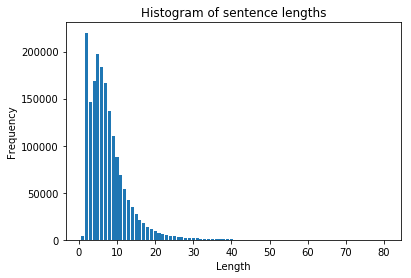

In [18]:
length_x = sorted([key for key in lengths.keys()])
length_y = [lengths[x] for x in length_x]
# threshold limit
length_x = length_x[:params['histogramCutoff']]
length_y = length_y[:params['histogramCutoff']]
plt.bar(length_x,length_y)
plt.title("Histogram of sentence lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

So it looks like setting the cutoff to 40 is good.

In [19]:
# let's look at the vocabulary size
tokens = {}
for group in tqdm(groups):
    for sentence in group:
        for token in sentence:
            if token not in tokens:
                tokens[token] = 0
            tokens[token] += 1

100%|██████████| 1539/1539 [00:02<00:00, 527.40it/s]


In [20]:
print("There are",len(tokens),"tokens.")

There are 90085 tokens.


In [21]:
# plot histogram of frequency of words
token_frequency = {}
for token in tokens:
    freq = tokens[token]
    if freq not in token_frequency:
        token_frequency[freq] = 0
    token_frequency[freq] += 1

In [22]:
knowns   = [token for token in tokens if token in glove]
unknowns = [token for token in tokens if token not in glove]
wordOrder = list(sorted(knowns, key=lambda x: tokens[x], reverse=True))

In [23]:
print(len(knowns),"knowns,", len(unknowns),"unknowns.")

58834 knowns, 31251 unknowns.


In [24]:
# setup vocabulary
cappedWordOrder = wordOrder[:params['vocabularyLimit']]

In [25]:
# setup weights for vocabulary
weights = [glove[token] for token in cappedWordOrder]

In [26]:
# add tags and their weights
additions = [PAD, UNK, SOS, EOS]
for tag in additions[::-1]:
    weight = glove[tag[1:-1]]
    weights = [weight] + weights
    cappedWordOrder = [tag] + cappedWordOrder

In [27]:
# create word2id and id2word
word2id, id2word = {}, {}
for i in range(len(cappedWordOrder)):
    word2id[cappedWordOrder[i]] = i
    id2word[i] = cappedWordOrder[i]

In [28]:
def addTags(group, eos=EOS, sos=SOS):
    return [[sos] + sentence + [eos] for sentence in group]

In [29]:
groups = processItems(addTags, groups, n_processes=7)

100%|██████████| 1539/1539 [00:05<00:00, 297.39it/s]


In [30]:
def doW2I(word, w2i=word2id, unk=UNK):
    if word in word2id:
        return word2id[word]
    return word2id[unk]

def sequenceToID(group, w2i=word2id, unk=UNK):
    return [[doW2I(token, w2i, unk) for token in sentence] for sentence in group]

In [31]:
"""
Convert sequence tokens to their respective IDs
"""
groups = processItems(sequenceToID, groups, n_processes=7)

100%|██████████| 1539/1539 [00:03<00:00, 347.64it/s]


In [32]:
"""
Now we're looking at the ratio of UNK tokens in the lines.
"""
unk_ratios = {}
for group in tqdm(groups):
    for line in group:
        ratio = line.count(word2id[UNK])/len(line)
        ratio = round(ratio, 2)
        if ratio not in unk_ratios:
            unk_ratios[ratio] = 0
        unk_ratios[ratio] += 1

100%|██████████| 1539/1539 [00:01<00:00, 853.59it/s]


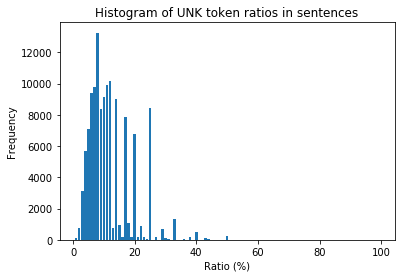

In [33]:
ratio_x = [i/100 for i in range(0, 100, 1)]
ratio_y = [unk_ratios[i] if i in unk_ratios else 0.0 for i in ratio_x]
ratio_x = [round(i * 100,0) for i in ratio_x]

plt.bar(ratio_x[1:],ratio_y[1:])
plt.title("Histogram of UNK token ratios in sentences")
plt.xlabel("Ratio (%)")
plt.ylabel("Frequency")
plt.show()

In [34]:
def countLines(groups):
    return sum([len(group) for group in groups])

# Processing for Language Models

In [35]:
# create input and output sequences of each subtitle xml
def createSequences(sequences):
    return [[sequences[i], sequences[i+1]] for i in range(len(sequences)-1)]

In [36]:
# batch operations with multiprocessing
sequences = processItems(createSequences, groups, n_processes=7)

100%|██████████| 1539/1539 [00:03<00:00, 396.68it/s]


In [37]:
# concatenate the sequences together
dataset = []
for sequence in tqdm(sequences):
    dataset += sequence

100%|██████████| 1539/1539 [00:00<00:00, 65553.30it/s]


In [38]:
len(dataset)

1771082

In [39]:
# remove sequences where the unk ratio is too high
clean_seq = []
for lines in tqdm(dataset):
    ratio_inp = lines[0].count(word2id[UNK])/len(lines[0])
    ratio_ans = lines[1].count(word2id[UNK])/len(lines[1])
    if ratio_ans <= 0.1 and ratio_inp <= 0.1:
        clean_seq.append(lines)
dataset = clean_seq

100%|██████████| 1771082/1771082 [00:01<00:00, 1084739.93it/s]


In [40]:
len(dataset)

1660896

In [41]:
# apply the cutoff
remainder = []
for lines in tqdm(dataset):
    if len(lines[0]) <= params['maxSequenceLength'] and len(lines[1]) <= params['maxSequenceLength']:
        remainder.append(lines)
dataset = remainder

100%|██████████| 1660896/1660896 [00:00<00:00, 1997627.59it/s]


In [42]:
len(dataset)

1654101

In [43]:
dists = {}
for lines in dataset:
    l = len(lines[0]) 
    if l not in dists:
        dists[l] = 0
    dists[l] += 1
for key in dists:
    if key > params['maxSequenceLength']:
        print("key:", key)

In [44]:
# generate example sequences so we have
# an idea of what the dataset looks like.
start = params['example_item_id']
examples = dataset[start:start+10]
examples = [[" ".join([id2word[word] for word in line]) for line in lines] for lines in examples]
for i in examples:
    print(i[0], "->", i[1])

<sos> your paycheck ? <eos> -> <sos> back off tucker , you don ' t sketch regulations . <eos>
<sos> back off tucker , you don ' t sketch regulations . <eos> -> <sos> what regulations ? <eos>
<sos> what regulations ? <eos> -> <sos> lock out devices must be in place during cleaning and maintenance of all heavy <unk> , ( motion 1989 ) <eos>
<sos> lock out devices must be in place during cleaning and maintenance of all heavy <unk> , ( motion 1989 ) <eos> -> <sos> ya ! <eos>
<sos> ya ! <eos> -> <sos> write to your congressman and hurry that up . <eos>
<sos> write to your congressman and hurry that up . <eos> -> <sos> congratulations , reznik . <eos>
<sos> and he ' s like , you know , babe this babe that ... <eos> -> <sos> chatting like mother fucking barry white . <eos>
<sos> chatting like mother fucking barry white . <eos> -> <sos> talking about what he is going to do to her , and how to make her <unk> feel and all that . <eos>
<sos> talking about what he is going to do to her , and how to

In [45]:
# split the dataset into training and validation data.
ratio = round(len(dataset) * params['trainRatio'])
random.shuffle(dataset)
train = dataset[:ratio]
validation = dataset[ratio:]

In [46]:
print(len(train), len(validation))

1488691 165410


In [47]:
# time to dump the dataset
container = {
    'id2word' : id2word,
    'word2id' : word2id,
    'train' : train,
    'validation': validation,
    'weights' : np.matrix(weights),
    'cutoff' : params['maxSequenceLength']
}

In [48]:
def convert_bytes(num):
    """
    this function will convert bytes to MB.... GB... etc
    """
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if num < 1024.0:
            return "%3.1f %s" % (num, x)
        num /= 1024.0

if params['saveDataset']:
    # save the dataset to a pickle file.
    output = open(params['datasetFile'], 'wb')
    pickle.dump(container, output)
    output.close()

    # save dataset preprocessing parameters
    params['example_filtering'] = examples
    with open(params['paramsJSONLocation'], 'w') as outfile:
        json.dump(params, outfile)

    print("Saved!", convert_bytes(os.stat(params['datasetFile']).st_size))
    print("Save location:", params['datasetFile'])
    print("dataset parameters save location:", params['paramsJSONLocation'])

Saved! 78.8 MB
Save location: dataset_ready.pkl
dataset parameters save location: subtitles_parameters.json
